In [2]:
import sys
!{sys.executable} -m pip install kagglehub


  Using cached kagglehub-1.0.0-py3-none-any.whl.metadata (40 kB)
  Using cached kagglesdk-0.1.15-py3-none-any.whl.metadata (13 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached kagglehub-1.0.0-py3-none-any.whl (70 kB)
Using cached kagglesdk-0.1.15-py3-none-any.whl (160 kB)
Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl (437 kB)
Using cached tqdm-4.67.3-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/4 [tqdm]
   ---------- ----------------------------- 1/4 [protobuf]
   ---------- ----------------------------- 1/4 [protobuf]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   ------------------------------ --------- 3/4 [kagglehub]
   -------------------------------

In [3]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

100%|██████████| 142k/142k [00:00<00:00, 1.58MB/s]

Extracting files...
Path to dataset files: C:\Users\mrgok\.cache\kagglehub\datasets\janiobachmann\bank-marketing-dataset\versions\1


In [7]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

In [8]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

In [9]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

In [12]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)

X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

## Métrica de clasificación objetivo

Se selecciona recall como metrica principal ya que en este contexto, un falso negativo significa un cliente que hubiera aceptado la subscipcion al deposito, pero un falso positivo solo implica un costo operativo menor, entonces maximizar el recall permite optimizar la detección de clientes con alta probabilidad de conversión, lo que optimiza el rendimiento de la campaña de marketing

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


## Modelo Regresion Logistica

In [ ]:
log_model = LogisticRegression(max_iter=5000)

param_grid_log = {
    "C":[0.01,0.1,1,10],
    "solver":["liblinear","lbfgs"]
}

grid_log = GridSearchCV(
    log_model,
    param_grid_log,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_log.fit(X_train,y_train)

best_log = grid_log.best_estimator_

## Modelo Random Forest

In [16]:
rf_model = RandomForestClassifier()

param_grid_rf = {
    "n_estimators":[100,200],
    "max_depth":[None,5,10],
    "min_samples_split":[2,5]
}

grid_rf = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_rf.fit(X_train,y_train)

best_rf = grid_rf.best_estimator_

## Modelo SVM

In [17]:
svm_model = SVC()

param_grid_svm = {
    "C":[0.1,1,10],
    "kernel":["linear","rbf"],
    "gamma":["scale","auto"]
}

grid_svm = GridSearchCV(
    svm_model,
    param_grid_svm,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_svm.fit(X_train,y_train)

best_svm = grid_svm.best_estimator_

In [26]:
models = {
    "Logistic Regression": best_log,
    "Random Forest": best_rf,
    "SVM": best_svm
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = recall_score(y_test,y_pred)

print(results)

best_model= max(results, key=results.get)
best_model = models[best_model_name]
print(f"Mejor modelo: {best_model_name} con recall de {results[best_model_name]:.4f}")

{'Logistic Regression': 0.6757263355201499, 'Random Forest': 0.6560449859418932, 'SVM': 0.6541705716963448}
Mejor modelo: Logistic Regression con recall de 0.6757


Comparando los 3 modelos se muestra que el de regresion logistica tiene un mejor recall con 0.67

In [27]:
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

print("Train Recall:", recall_score(y_train,train_pred))
print("Test Recall:", recall_score(y_test,test_pred))

Train Recall: 0.6418758882046424
Test Recall: 0.6757263355201499


Se muestra que el recall de entrenamiento es menor que al de prueba, lo que indica que no hay overfitting

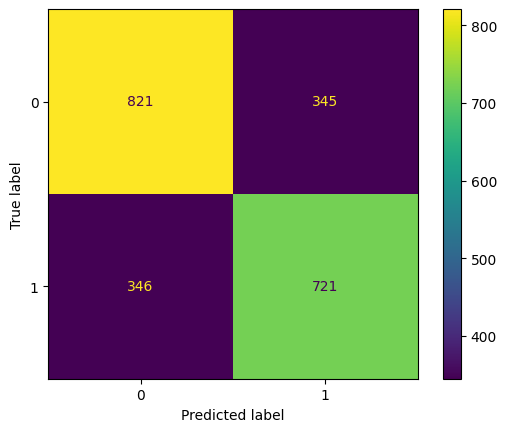

In [29]:
cm = confusion_matrix(y_test,test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


La matriz muestra que el modelo logro clasificar correctamente 721 verdaderos positivos, aunque todavía existen 346 falsos negativos, lo que indica que aún hay margen de mejora para detectar más clientes potenciales.

In [30]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1166
           1       0.68      0.68      0.68      1067

    accuracy                           0.69      2233
   macro avg       0.69      0.69      0.69      2233
weighted avg       0.69      0.69      0.69      2233



El reporte de clasificación muestra valores equilibrados entre precision, recall y f1-score (~0.69), lo que indica un rendimiento consistente entre clases y ausencia de sesgos graves hacia una categoría

## Conclusiones

Tras entrenar y optimizar los modelos, se muestra que el mejor fue el de regresion logistica, con un recall de 0.67, identificando una mayor proporcion de clientes que realmente aceptarian el depósito, el analisis mostro que el recall de entrenamiento (0.6419) es ligeramente menor que el de prueba (0.6757), lo cual indica que el modelo no presenta overfitting y mantiene una buena capacidad de generalización. Esto convierte el modelo en una herramienta util para apoyar campañas de marketing dirigidas, permitiendo identificar la mayor cantidad posible de clientes con probabilidad de suscripción al depósito.